## Reshape

In [7]:
import os
from PIL import Image
file_dir = 'C:\\Users\\User\\GAN\\SA'
files = os.listdir(file_dir)
count = 0
for file in files: 
    img = Image.open(file_dir +'\\' +file)
    (w, h) = img.size
    print('w=%d, h=%d', w, h)
    #img.show()
    count += 1
    new_img = img.resize((34*1.5,46*1.5))
    #new_img.show()
    new_img.save('C:\\Users\\User\\GAN\\SA'+'\\' +str(count)+'.png')

w=%d, h=%d 68 92


TypeError: integer argument expected, got float

## Lable Image

In [1]:
import os
import cv2
import numpy as np
file_dir = 'C:\\Users\\User\\GAN\\SA'
files = os.listdir(file_dir)
count = 0
images = []
for file in files: 
    img = cv2.imread(file_dir +'\\' +file)
    #(w, h) = img.size
    #print('w=%d, h=%d', w, h)
    #img.show()
    count += 1
    new_img = cv2.resize(img,(34, 46))
    #new_img.show()
    #imgcv = cv2.cvtColor(np.asarray(new_img),cv2.COLOR_RGB2BGR) 
    
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)
    images.append(new_img)
images = np.array(images)

In [46]:
def decode(num):
    
    if num // 13 == 0:
        numID = 'S'+str(trans(num))
    elif num // 13 == 1:
        numID = 'H'+str(trans(num))
    elif num // 13 == 2:
        numID = 'D'+str(trans(num))
    elif num // 13 == 3:
        numID = 'C'+str(trans(num))
    return numID

def trans(num):
    num += 1
    if num % 13 == 1:
        return 'A'
    elif num % 13 == 11:
        return 'J'
    elif num % 13 == 12:
        return 'Q'
    elif num % 13 == 0:
        return 'K'
    else:
        return str(num % 13)
        

In [3]:
import pickle
classifier = pickle.load(open('C:\\Users\\User\\Poker\\classifier.p','rb'))

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.




In [4]:
lableImg = []
for i in np.argmax(classifier.predict(images),axis=1):
    lableImg.append(i)

In [78]:
lableImg

[4,
 22,
 51,
 48,
 19,
 16,
 3,
 22,
 46,
 39,
 48,
 3,
 45,
 2,
 43,
 39,
 45,
 28,
 13,
 43,
 9,
 14,
 0,
 36,
 19,
 17,
 30,
 44,
 21,
 13,
 18,
 24,
 20,
 44,
 12,
 6,
 17,
 10,
 32,
 38,
 27,
 2,
 39,
 1,
 6,
 22,
 11,
 39,
 9,
 38,
 6,
 3,
 43,
 43,
 32,
 28,
 33,
 47,
 10,
 35,
 47,
 28,
 33,
 10,
 35,
 15,
 47,
 28,
 43,
 3,
 5,
 38,
 40,
 36,
 3,
 40,
 18,
 16,
 11,
 19,
 12,
 0,
 15,
 18,
 15,
 19,
 41,
 39,
 51,
 13,
 11,
 9,
 31,
 2,
 5,
 19,
 9,
 40,
 12,
 19,
 38,
 15,
 2,
 17,
 40,
 22,
 46,
 19,
 21,
 4,
 10,
 3,
 48,
 47,
 39,
 43,
 16,
 39,
 11,
 36,
 48,
 14,
 3,
 9,
 34,
 49,
 45,
 0,
 47,
 15,
 31,
 28,
 3,
 26,
 42,
 7,
 47,
 0,
 6,
 39,
 42,
 16,
 14,
 20,
 9,
 25,
 48,
 39,
 14,
 49,
 44,
 42,
 7,
 17,
 23,
 43,
 24,
 47,
 18,
 49,
 45,
 35,
 10,
 38,
 25,
 26,
 48,
 24,
 8,
 17,
 14,
 7,
 2,
 11,
 20,
 49,
 7,
 34,
 35,
 28,
 51,
 14,
 25,
 11,
 42,
 41,
 47,
 49,
 28,
 49,
 28,
 24,
 5,
 40,
 4,
 12,
 27,
 14,
 9,
 29,
 42,
 17,
 26,
 8,
 11,
 49,
 29,
 42,
 

In [5]:
pickle.dump(lableImg, open('lableImg.p','wb'))

## One class GAN

In [27]:
import tensorflow as tf
import os
import pickle
from IPython.display import clear_output
import keras.backend as K
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# config = tf.ConfigProto(allow_soft_placement = True)
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.5)
# config.gpu_options.allow_growth = True
 
# sess0 = tf.InteractiveSession(config = config)

def mutual_info_loss(c, c_given_x):
    """The mutual information metric we aim to minimize"""
    eps = 1e-8
    conditional_entropy = K.mean(- K.sum(K.log(c_given_x + eps) * c, axis=1))
    entropy = K.mean(- K.sum(K.log(c + eps) * c, axis=1))

    return conditional_entropy + entropy
'''
生成器（generator）
首先，建立一個“生成器（generator）”模型，它將一個向量（從潛在空間 - 在訓練期間隨機取樣）轉換為候選影象。
GAN通常出現的許多問題之一是generator卡在生成的影象上，看起來像噪聲。一種可能的解決方案是在鑑別器（discriminator）
和生成器（generator）上使用dropout。
'''
import keras
from keras import layers
import numpy as np

latent_dim = 46
height = 92
width = 68
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# 首先，將輸入轉換為16x16 128通道的feature map
# x = layers.Dense(32 * 46 * 17)(generator_input)
# x = layers.LeakyReLU()(x)
# # x = layers.Dense(128 * 46 * 17)(x)
# # x = layers.LeakyReLU()(x)
x = layers.Dense(128 * 46 * 34)(generator_input)
x = layers.LeakyReLU()(x)
#x = layers.Dropout(0.3)(x)
x = layers.Reshape((46, 34, 128))(x)

# 然後，添加捲積層
# x = layers.Conv2D(256, 5, padding='same')(x)
# x = layers.LeakyReLU()(x)

# 上取樣至 32 x 32
x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.Dropout(0.2)(x)
x = layers.LeakyReLU()(x)
# 新增更多的卷積層
# x = layers.Conv2D(256, 5, padding='same')(x)
# x = layers.LeakyReLU()(x)
# x = layers.Conv2D(256, 5, padding='same')(x)
# x = layers.LeakyReLU()(x)
# x = layers.Conv2D(256, 5, padding='same')(x)
# x = layers.LeakyReLU()(x)

# 生成一個 32x32 1-channel 的feature map
x = layers.Conv2D(channels, 16, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()


# In[8]:


'''
discriminator(鑑別器)
建立鑑別器模型，它將候選影象（真實的或合成的）作為輸入，並將其分為兩類：“生成的影象”或“來自訓練集的真實影象”。
'''
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(128)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(64, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
#x = layers.Dropout(0.25)(x)
x = layers.Conv2D(32, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(32)(x)
x = layers.LeakyReLU()(x)
#x = layers.Dropout(0.25)(x)
x = layers.Conv2D(32, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
# 重要的技巧（新增一個dropout層）
x = layers.Dropout(0,4)(x)

# 分類層
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# In[11]:

# 為了訓練穩定，在優化器中使用學習率衰減和梯度限幅（按值）。
discriminator_optimizer = keras.optimizers.adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, amsgrad=False,epsilon=1e-08)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')


# In[16]:

generator = pickle.load(open('generator3.p','rb'))
discriminator = pickle.load(open('discriminator3.p','rb'))
'''
The adversarial network:對抗網路
最後，設定GAN，它連結生成器（generator）和鑑別器（discrimitor）。 這是一種模型，經過訓練，
將使生成器（generator）朝著提高其愚弄鑑別器（discrimitor）能力的方向移動。 該模型將潛在的空間點轉換為分類決策，
“假的”或“真實的”，並且意味著使用始終是“這些是真實影象”的標籤來訓練。 所以訓練`gan`將以一種方式更新
“發生器”的權重，使得“鑑別器”在檢視假影象時更可能預測“真實”。 非常重要的是，將鑑別器設定為在訓練
期間被凍結（不可訓練）：訓練“gan”時其權重不會更新。 如果在此過程中可以更新鑑別器權重，那麼將訓練鑑別
器始終預測“真實”。
'''
# 將鑑別器（discrimitor）權重設定為不可訓練（僅適用於`gan`模型）
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
#losses = [ mutual_info_loss]
gan_optimizer = keras.optimizers.adam(learning_rate=4e-6, beta_1=0.9, beta_2=0.999, amsgrad=False,epsilon=1e-08)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')


# In[19]:


# gan = pickle.load(open('gan.p','rb'))
'''
  開始訓練了。
  每個epoch：
   *在潛在空間中繪製隨機點（隨機噪聲）。
   *使用此隨機噪聲生成帶有“generator”的影象。
   *將生成的影象與實際影象混合。
   *使用這些混合影象訓練“鑑別器”，使用相應的目標，“真實”（對於真實影象）或“假”（對於生成的影象）。
   *在潛在空間中繪製新的隨機點。
   *使用這些隨機向量訓練“gan”，目標都是“這些是真實的影象”。 這將更新發生器的權重（僅因為鑑別器在“gan”內被凍結）
   以使它們朝向獲得鑑別器以預測所生成影象的“這些是真實影象”，即這訓練發生器欺騙鑑別器。
'''
import os
from keras.preprocessing import image
import cv2
import numpy as np
'''
# 匯入CIFAR10資料集
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# 從CIFAR10資料集中選擇frog類（class 6）
x_train = x_train[y_train.flatten() == 6]

# 標準化資料
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.
'''

dirPath = 'C:/Users/User/GAN/SA'
SA = [f for f in os.listdir(dirPath) if os.path.isfile(os.path.join(dirPath, f))]
x_train = []
for img in SA:
    imgcv = cv2.imread(dirPath+'/'+img)
    imgcv = cv2.cvtColor(imgcv, cv2.COLOR_BGR2RGB)
    x_train.append(imgcv)
x_train = np.array(x_train)
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.


iterations = 450000000000
batch_size = 20
save_dir = '.\\gan_image3'

start = 0 
# 開始訓練迭代
for step in range(30500,iterations):
    # 在潛在空間中抽樣隨機點
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    # 將隨機抽樣點解碼為假影象
    generated_images = generator.predict(random_latent_vectors)
    
    # 將假影象與真實影象進行比較
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    # 組裝區別真假影象的標籤
    labels = np.concatenate([np.ones((batch_size, 1)),
                            np.zeros((batch_size, 1))])
    # 重要的技巧，在標籤上新增隨機噪聲
    labels += 0.05 * np.random.random(labels.shape)
    
    # 訓練鑑別器（discrimitor）
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    # 在潛在空間中取樣隨機點
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    # 彙集標有“所有真實影象”的標籤
    misleading_targets = np.zeros((batch_size, 1))
    
    # 訓練生成器（generator）（通過gan模型，鑑別器（discrimitor）權值被凍結）
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
    if step % 100 == 0:
        # 儲存網路權值
        gan.save_weights('gan.h5')
        if step % 100 == 0:
            print(discriminator.predict(combined_images))
        # 輸出metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # 儲存生成的影象
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, str(step) + '.png'))
        
        pickle.dump(discriminator,open('discriminator3.p','wb'))
        pickle.dump(generator,open('generator3.p','wb'))
        pickle.dump(gan,open('gan3.p','wb'))
        
        # 儲存真實影象，以便進行比較
#         img = image.array_to_img(real_images[0] * 255., scale=False)
#         img.save(os.path.join(save_dir, 'real_SA' + str(step) + '.png'))
    if step % 1000 == 0:
        clear_output()

# In[ ]:


# 繪圖
import matplotlib.pyplot as plt

# 在潛在空間中抽樣隨機點
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# 將隨機抽樣點解碼為假影象
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 46)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 200192)            9409024   
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 200192)            0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 46, 34, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 92, 68, 128)       262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 92, 68, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 92, 68, 256)       8194

C:\Users\User\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


KeyboardInterrupt: 

## Classify GAN

In [5]:
disc_sample_weight

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3.])]

In [102]:
import tensorflow as tf
import os
import pickle
from IPython.display import clear_output
import keras.backend as K
from keras.layers import Input, Dense, Reshape, Flatten, Embedding, Dropout
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# config = tf.ConfigProto(allow_soft_placement = True)
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.5)
# config.gpu_options.allow_growth = True
 
# sess0 = tf.InteractiveSession(config = config)

def mutual_info_loss(c, c_given_x):
    """The mutual information metric we aim to minimize"""
    eps = 1e-8
    conditional_entropy = K.mean(- K.sum(K.log(c_given_x + eps) * c, axis=1))
    entropy = K.mean(- K.sum(K.log(c + eps) * c, axis=1))

    return conditional_entropy + entropy
'''
生成器（generator）
首先，建立一個“生成器（generator）”模型，它將一個向量（從潛在空間 - 在訓練期間隨機取樣）轉換為候選影象。
GAN通常出現的許多問題之一是generator卡在生成的影象上，看起來像噪聲。一種可能的解決方案是在鑑別器（discriminator）
和生成器（generator）上使用dropout。
'''
import keras
from keras import layers
import numpy as np

num_classes = 52
latent_dim = 46
height = 92
width = 68
channels = 3

# 兩個input，分別是亂數、類別
latent = keras.Input(shape=(latent_dim,))
image_class = Input(shape=(1,), dtype='int32')
cls = Embedding(num_classes, latent_dim,
                embeddings_initializer='glorot_normal')(image_class)

generator_input = layers.add([latent, cls])
# 首先，將輸入轉換為16x16 128通道的feature map
# x = layers.Dense(32 * 46 * 17)(generator_input)
# x = layers.LeakyReLU()(x)
# # x = layers.Dense(128 * 46 * 17)(x)
# # x = layers.LeakyReLU()(x)
x = layers.Dense(128 * 46 * 34)(generator_input)
x = layers.LeakyReLU()(x)
#x = layers.Dropout(0.3)(x)
x = layers.Reshape((46, 34, 128))(x)

# 然後，添加捲積層
# x = layers.Conv2D(256, 5, padding='same')(x)
# x = layers.LeakyReLU()(x)

# 上取樣至 32 x 32
x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.Dropout(0.2)(x)
x = layers.LeakyReLU()(x)
# 新增更多的卷積層
# x = layers.Conv2D(256, 5, padding='same')(x)
# x = layers.LeakyReLU()(x)
# x = layers.Conv2D(256, 5, padding='same')(x)
# x = layers.LeakyReLU()(x)
# x = layers.Conv2D(256, 5, padding='same')(x)
# x = layers.LeakyReLU()(x)

# 生成一個 32x32 1-channel 的feature map
x = layers.Conv2D(channels, 16, activation='tanh', padding='same')(x)
generator = keras.models.Model([latent, image_class], x)
generator.summary()


# In[8]:


'''
discriminator(鑑別器)
建立鑑別器模型，它將候選影象（真實的或合成的）作為輸入，並將其分為兩類：“生成的影象”或“來自訓練集的真實影象”。
'''
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(128)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(64, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
#x = layers.Dropout(0.25)(x)
x = layers.Conv2D(32, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(32)(x)
x = layers.LeakyReLU()(x)
#x = layers.Dropout(0.25)(x)
x = layers.Conv2D(32, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
# 重要的技巧（新增一個dropout層）
x = layers.Dropout(0,4)(x)

# 分類層
isFake = layers.Dense(1, activation='sigmoid')(x)
classDetac = layers.Dense(num_classes, activation ='softmax')(x)

discriminator = keras.models.Model(discriminator_input, [isFake,classDetac])
discriminator.summary()

# In[11]:
generator = pickle.load(open('generatorClass.p','rb'))
discriminator = pickle.load(open('discriminatorClass.p','rb'))
# 為了訓練穩定，在優化器中使用學習率衰減和梯度限幅（按值）。
discriminator_optimizer = keras.optimizers.adam(learning_rate=0.00002, beta_1=0.9, beta_2=0.999, amsgrad=False,epsilon=1e-08)
discriminator.compile(optimizer=discriminator_optimizer, loss=['binary_crossentropy', 'sparse_categorical_crossentropy'])


# In[16]:


'''
The adversarial network:對抗網路
最後，設定GAN，它連結生成器（generator）和鑑別器（discrimitor）。 這是一種模型，經過訓練，
將使生成器（generator）朝著提高其愚弄鑑別器（discrimitor）能力的方向移動。 該模型將潛在的空間點轉換為分類決策，
“假的”或“真實的”，並且意味著使用始終是“這些是真實影象”的標籤來訓練。 所以訓練`gan`將以一種方式更新
“發生器”的權重，使得“鑑別器”在檢視假影象時更可能預測“真實”。 非常重要的是，將鑑別器設定為在訓練
期間被凍結（不可訓練）：訓練“gan”時其權重不會更新。 如果在此過程中可以更新鑑別器權重，那麼將訓練鑑別
器始終預測“真實”。
'''
# 將鑑別器（discrimitor）權重設定為不可訓練（僅適用於`gan`模型）

discriminator.trainable = False

fakeImg = generator([latent, image_class])
fake, aux = discriminator(fakeImg)

gan = keras.models.Model([latent, image_class], [fake, aux])
#losses = [ mutual_info_loss]
gan_optimizer = keras.optimizers.adam(learning_rate=0.00002, beta_1=0.9, beta_2=0.999, amsgrad=False,epsilon=1e-08)
gan.compile(optimizer=gan_optimizer, loss=['binary_crossentropy', 'sparse_categorical_crossentropy'])
gan.summary()

# In[19]:


# gan = pickle.load(open('gan.p','rb'))
'''
  開始訓練了。
  每個epoch：
   *在潛在空間中繪製隨機點（隨機噪聲）。
   *使用此隨機噪聲生成帶有“generator”的影象。
   *將生成的影象與實際影象混合。
   *使用這些混合影象訓練“鑑別器”，使用相應的目標，“真實”（對於真實影象）或“假”（對於生成的影象）。
   *在潛在空間中繪製新的隨機點。
   *使用這些隨機向量訓練“gan”，目標都是“這些是真實的影象”。 這將更新發生器的權重（僅因為鑑別器在“gan”內被凍結）
   以使它們朝向獲得鑑別器以預測所生成影象的“這些是真實影象”，即這訓練發生器欺騙鑑別器。
 '''
import os
from keras.preprocessing import image
import cv2
import numpy as np
'''
# 匯入CIFAR10資料集
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# 從CIFAR10資料集中選擇frog類（class 6）
x_train = x_train[y_train.flatten() == 6]

# 標準化資料
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.
'''

dirPath = 'C:/Users/User/GAN/SA'
SA = [f for f in os.listdir(dirPath) if os.path.isfile(os.path.join(dirPath, f))]
x_train = []
for img in SA:
    imgcv = cv2.imread(dirPath+'/'+img)
    imgcv = cv2.cvtColor(imgcv, cv2.COLOR_BGR2RGB)
    x_train.append(imgcv)
x_train = np.array(x_train)
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

lableImg = pickle.load(open('lableImg.p','rb'))

iterations = 450000000000
batch_size = 20
save_dir = '.\\gan_image3'

start = 0 
# 開始訓練迭代
for step in range(15200,iterations):
    # 在潛在空間中抽樣隨機點
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    # 隨機選擇化哪個類別
    random_labels = np.random.randint(0, num_classes, batch_size)
    # 將隨機抽樣點解碼為假影象
    generated_images = generator.predict([random_latent_vectors,random_labels.reshape((-1, 1))])
    
    # 將假影象與真實影象進行比較
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    # 取真實類別的標籤
    
    
    # 組裝區別真假影象的標籤
    labels = np.concatenate([np.ones((batch_size, 1)),
                            np.zeros((batch_size, 1))])
    # 組裝區別真假類別的標籤
    claLabels = lableImg[start: stop]
    combined_clsLable = np.concatenate([random_labels, claLabels])
    #combined_clsLable = np.concatenate([np.negative(np.ones((batch_size))), claLabels])
    
    # 重要的技巧，在標籤上新增隨機噪聲
    labels += 0.05 * np.random.random(labels.shape)
    
    # Assign sample weight
    disc_sample_weight = [np.ones(2 * (batch_size)),
                                  np.concatenate((np.zeros(batch_size) ,
                                                  np.ones(batch_size)*3))]
    # 訓練鑑別器（discrimitor）
    d_loss = discriminator.train_on_batch(combined_images, [labels,combined_clsLable], sample_weight=disc_sample_weight)
    

    
    # 彙集標有“所有真實影象”的標籤
    misleading_targets = np.zeros((batch_size, 1))
    
    # 再做一個新的亂數和標籤
    # 在潛在空間中抽樣隨機點
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    # 隨機選擇化哪個類別
    random_labels = np.random.randint(0, num_classes, batch_size)
    
    # 訓練生成器（generator）（通過gan模型，鑑別器（discrimitor）權值被凍結）
    a_loss = gan.train_on_batch([random_latent_vectors,random_labels.reshape((-1, 1))], [misleading_targets,random_labels])
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
    if step % 100 == 0:
        # 儲存網路權值
        gan.save_weights('gan.h5')
        if step % 100 == 0:
            print(discriminator.predict(combined_images))
        # 輸出metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # 儲存生成的影象
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, str(step) + '.png'))
        
        pickle.dump(discriminator,open('discriminatorClass.p','wb'))
        pickle.dump(generator,open('generatorClass.p','wb'))
        pickle.dump(gan,open('ganClass.p','wb'))
        
        # 儲存真實影象，以便進行比較
#         img = image.array_to_img(real_images[0] * 255., scale=False)
#         img.save(os.path.join(save_dir, 'real_SA' + str(step) + '.png'))
    if step % 1000 == 0:
        clear_output()

# In[ ]:


# 繪圖
import matplotlib.pyplot as plt

# 在潛在空間中抽樣隨機點
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# 將隨機抽樣點解碼為假影象
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

KeyboardInterrupt: 

In [44]:
random_labels

array([ 7, 35, 25, 27, 34,  7, 39, 12, 22, 36,  6, 33, 17, 22, 41,  4, 10,
       45, 23,  3])

In [47]:

for i in np.argmax(discriminator.predict(generated_images)[1],axis=1):
    print(decode(i))
np.argmax(discriminator.predict(generated_images)[1],axis=1)

SA
SA
SA
SA
SA
SA
SA
SA
SA
SA
SA
SA
SA
SA
SA
SA
SA
SA
SA
SA


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [20]:
np.argmax(discriminator.predict(generated_images)[1],axis=1)

array([34, 36, 36, 36, 36, 36, 36, 36, 14, 34, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36], dtype=int64)

In [21]:
combined_clsLable

array([34, 46, 48,  9, 19,  5, 30, 51, 11, 37,  7, 29, 37, 43, 10, 51, 13,
       32,  1, 37,  7, 37,  4, 19,  3,  3, 43, 50, 42, 14, 31, 21, 46, 50,
       14, 17, 31, 21, 41, 44], dtype=int64)

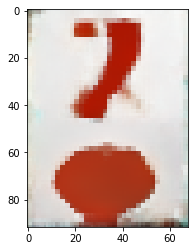

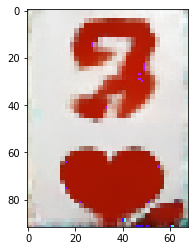

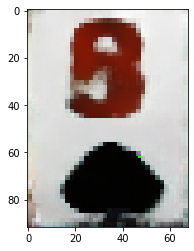

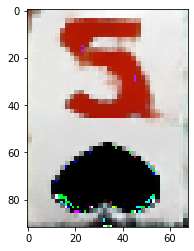

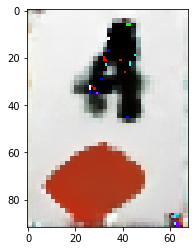

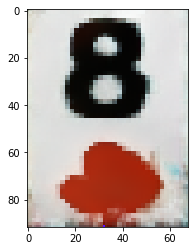

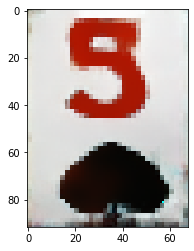

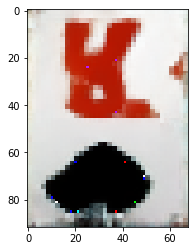

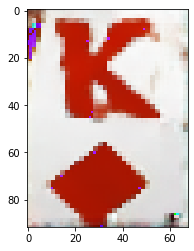

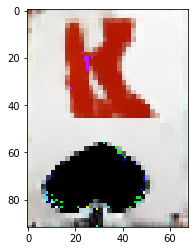

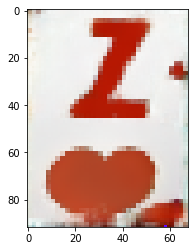

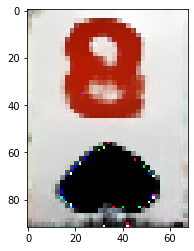

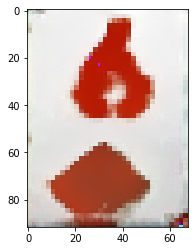

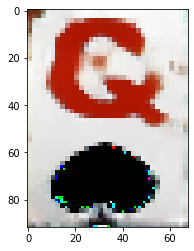

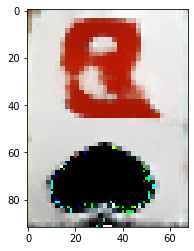

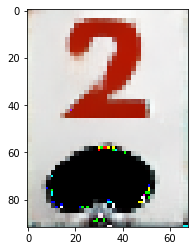

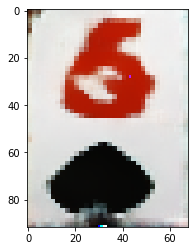

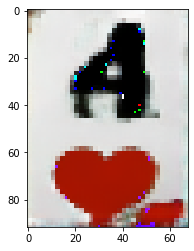

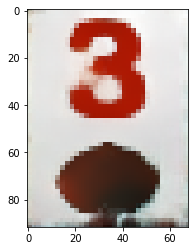

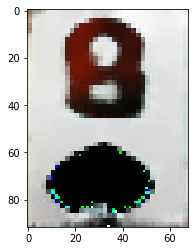

In [120]:
import matplotlib.pyplot as plt
import numpy as np
from keras_preprocessing import image
import pickle


latent_dim = 46
height = 92
width = 68
channels = 3
picNum = 20
# 在潛在空間中抽樣隨機點
random_latent_vectors = np.random.normal(size=(picNum, latent_dim))
l = []
for i in range(picNum):
    l.append(91)
# 將隨機抽樣點解碼為假影象
generated_images = generator.predict([random_latent_vectors,np.array(l)])

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

In [9]:
import pickle
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from IPython.display import clear_output

latent_dim = 46
height = 46
width = 35
channels = 3

dirPath = 'C:/Users/User/GAN/SA'
SA = [f for f in os.listdir(dirPath) if os.path.isfile(os.path.join(dirPath, f))]
x_train = []
for img in SA:
    imgcv = cv2.imread(dirPath+'/'+img)
    x_train.append(imgcv)
x_train = np.array(x_train)
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.


iterations = 450000000000
batch_size = 20
save_dir = '.\\gan_image2'
start = 0 
# 開始訓練迭代
generator = pickle.load(open('generator.p','rb'))
discriminator = pickle.load(open('discriminator.p','rb'))
gan = pickle.load(open('gan.p','rb'))
for step in range(17000,iterations):
    # 在潛在空間中抽樣隨機點
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    # 將隨機抽樣點解碼為假影象
    generated_images = generator.predict(random_latent_vectors)
    
    # 將假影象與真實影象進行比較
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    # 組裝區別真假影象的標籤
    labels = np.concatenate([np.ones((batch_size, 1)),
                            np.zeros((batch_size, 1))])
    # 重要的技巧，在標籤上新增隨機噪聲
    labels += 0.05 * np.random.random(labels.shape)
    
    # 訓練鑑別器（discrimitor）
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    # 在潛在空間中取樣隨機點
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    # 彙集標有“所有真實影象”的標籤
    misleading_targets = np.zeros((batch_size, 1))
    
    # 訓練生成器（generator）（通過gan模型，鑑別器（discrimitor）權值被凍結）
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
    if step % 100 == 0:
        # 儲存網路權值
        gan.save_weights('gan.h5')
        if step % 500 == 0:
            print(discriminator.predict(combined_images))
        # 輸出metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # 儲存生成的影象
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_SA' + str(step) + '.png'))

        # 儲存真實影象，以便進行比較
#         img = image.array_to_img(real_images[0] * 255., scale=False)
#         img.save(os.path.join(save_dir, 'real_SA' + str(step) + '.png'))
    if step % 1000 == 0:
        clear_output()

# In[ ]:


# 繪圖
import matplotlib.pyplot as plt

# 在潛在空間中抽樣隨機點
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# 將隨機抽樣點解碼為假影象
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

discriminator loss at step 29100: -18772430000.0
adversarial loss at step 29100: 0.0
discriminator loss at step 29200: -17070129000.0
adversarial loss at step 29200: 0.0
discriminator loss at step 29300: -32954240000.0
adversarial loss at step 29300: 0.0
discriminator loss at step 29400: -28285495000.0
adversarial loss at step 29400: 0.0
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
discriminator loss at step 29500: -27379569000.0
adversarial loss at step 29500: 0.0


KeyboardInterrupt: 

In [11]:
import pickle
pickle.dump(discriminator,open('discriminator.p','wb'))
pickle.dump(generator,open('generator.p','wb'))
pickle.dump(gan,open('gan.p','wb'))

In [1]:
import pickle
generator = pickle.load(open('generator.p','rb'))
discriminator = pickle.load(open('discriminator.p','rb'))
gan = pickle.load(open('gan.p','rb'))

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


C:\Users\User\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



C:\Users\User\Anaconda3\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [60]:
# generator(gan_input)
# gan.summary()
# keras.datasets.cifar10.load_data()[0][0].shape
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()
print(x_train.shape)
# 從CIFAR10資料集中選擇frog類（class 6）
x_train = x_train[y_train.flatten() == 6]

# 標準化資料
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

x_train.shape

(50000, 32, 32, 3)


(5000, 32, 32, 3)

In [63]:
import cv2
import os
import numpy as np
dirPath = 'C:/Users/User/GAN/SA'
SA = [f for f in os.listdir(dirPath) if os.path.isfile(os.path.join(dirPath, f))]
x_train = []
for img in SA:
    imgcv = cv2.imread(dirPath+'/'+img)
    x_train.append(imgcv)
x_train = np.array(x_train)
x_train.shape


(64, 46, 35, 3)

In [178]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(256, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
# 重要的技巧（新增一個dropout層）
x = layers.Dropout(0.4,4)(x)

# 分類層
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()
discriminator_optimizer = keras.optimizers.RMSprop(lr=8e-4, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

discriminator.train_on_batch(combined_images, labels)
print(discriminator.predict(combined_images))
print('labels: ',labels)

TypeError: 'int' object is not iterable

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

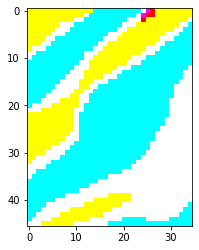

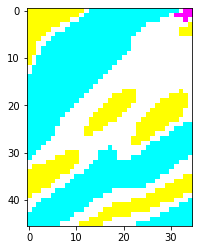

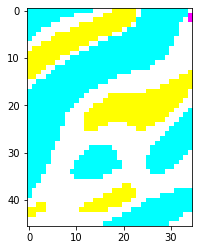

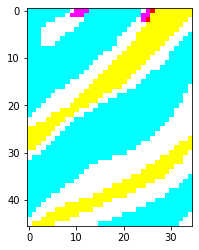

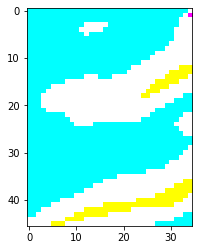

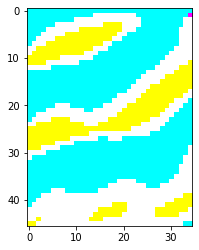

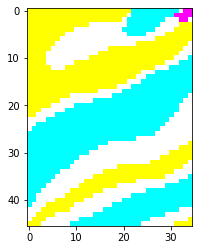

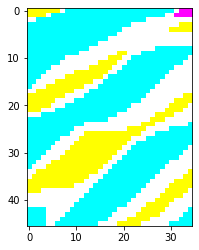

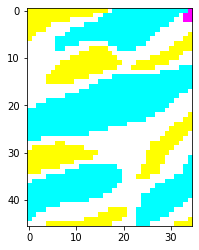

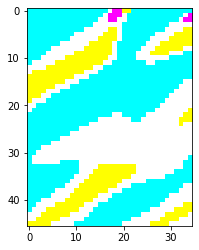

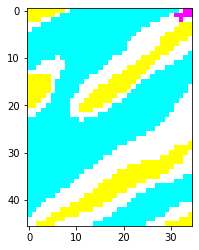

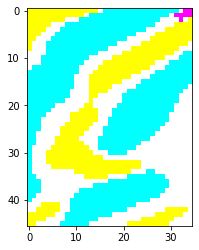

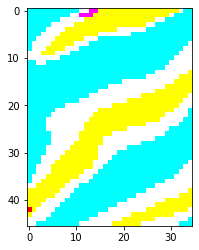

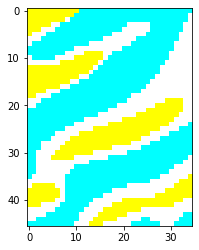

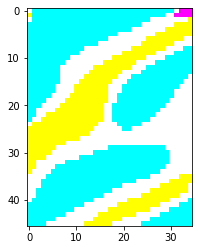

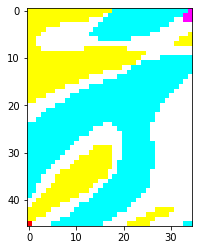

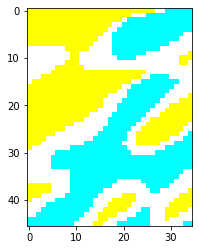

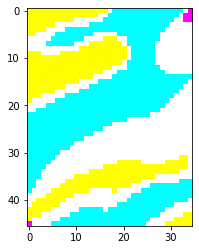

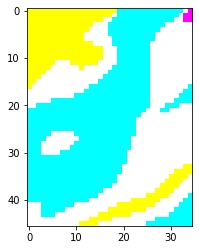

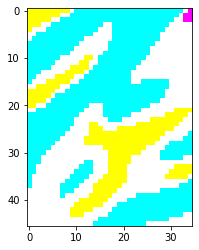

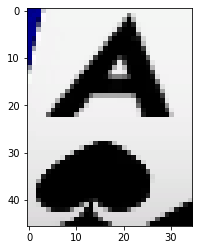

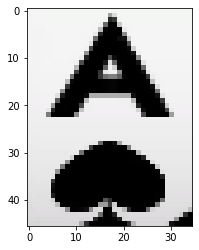

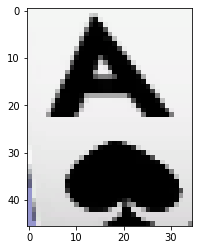

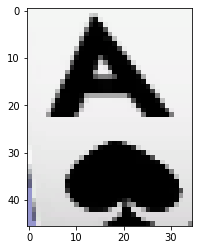

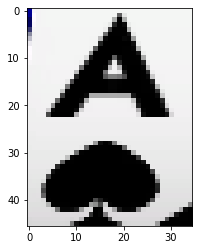

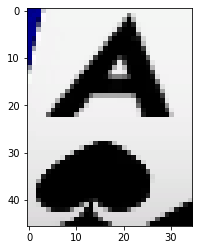

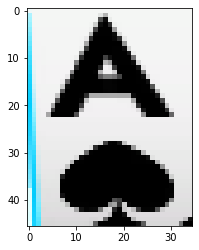

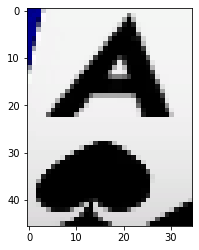

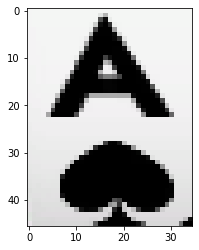

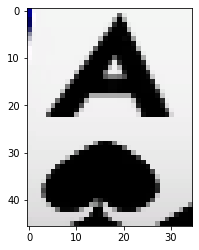

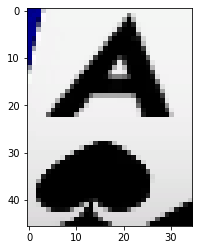

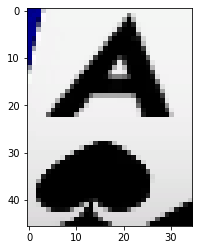

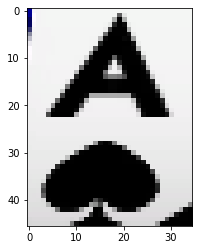

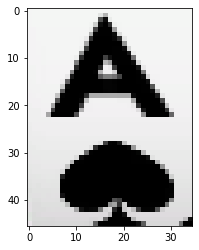

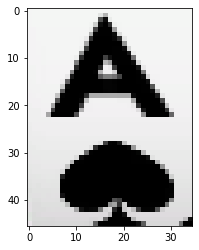

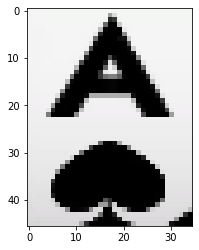

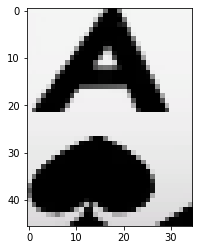

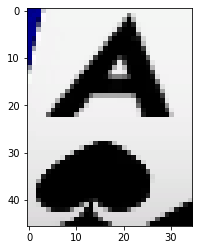

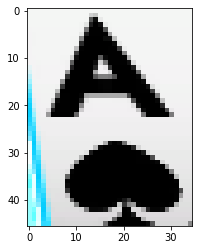

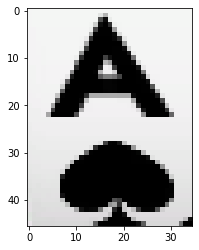

In [95]:
for i in combined_images:
    #img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(i)
    
plt.show()

In [138]:
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# 從CIFAR10資料集中選擇frog類（class 6）
x_train = x_train[y_train.flatten() == 6]


In [12]:
file
file.replace('_','')

'generatedSA99900.png'

In [17]:
import os
files = os.listdir(file_dir)
file_dir = 'C:\\Users\\User\\GAN\\gan_image2\\'
for file in files: 
    
    oldname=file_dir+file 
    file = file.replace('generatedSA','')
    newname=file_dir+file
    os.rename(oldname,newname)

In [ ]:
import os
import cv2
img_array = []
file_dir = 'C:\\Users\\User\\GAN\\gan_image2'
files = os.listdir(file_dir)
files.sort(key=lambda x: int(x.split('.')[0]))
for file in files:
    
    if file.endswith(r'.png'):

        img = cv2.imread(file_dir+'/'+file)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)


out = cv2.VideoWriter('GANvedio'+ 'Pocker' +'.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size,)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

## Reverse

In [28]:
import keras
from keras import layers
import numpy as np
import pickle
generator = pickle.load(open('generator.p','rb'))

import tensorflow as tf
import os
from IPython.display import clear_output
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# config = tf.ConfigProto(allow_soft_placement = True)
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 1)
# config.gpu_options.allow_growth = True
 
# sess0 = tf.InteractiveSession(config = config)

latent_dim = 46
height = 46
width = 35
channels = 3

decodedGenerator = layers.Input(shape=(height, width, channels))

x = layers.Flatten()(decodedGenerator)
x = layers.Dense(256 * 46 * 35)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(latent_dim)(x)

decodedGenerator = keras.models.Model(decodedGenerator, x)
decodedGenerator.summary()

decodedGenerator_optimizer = keras.optimizers.RMSprop(lr=8e-4, clipvalue=1.0, decay=1e-8)
decodedGenerator.compile(optimizer=decodedGenerator_optimizer, loss='mean_squared_error')

generator.summary()
#====================================================================


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 46, 35, 3)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4830)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 412160)            1991144960
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 412160)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 46)                18959406  
Total params: 2,010,104,366
Trainable params: 2,010,104,366
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)           

C:\Users\User\Anaconda3\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [29]:
for i in range(100000):
    
    # 在潛在空間中抽樣隨機點
    random_latent_vectors = np.random.normal(size=(2, latent_dim))

    # 將隨機抽樣點解碼為假影象
    generated_images = generator.predict(random_latent_vectors)

    decodeLoss = decodedGenerator.train_on_batch(generated_images,random_latent_vectors)
'''    
    if i% 100 == 0:
        print(decodeLoss)
        pickle.dump(open('decoder.p','rb'))
        
        decodeImages = generator.predict(decodedGenerator.predict(generated_images))
        
        for i in range(3):
            print('original: \n')
            img = image.array_to_img(generated_images[i] * 255., scale=False)
            plt.figure()
            plt.imshow(img)
            print('decode: \n')
            img = image.array_to_img(decodeImages[i] * 255., scale=False)
            plt.figure()
            plt.imshow(img)
            
            

        plt.show()
'''

ResourceExhaustedError: OOM when allocating tensor with shape[4830,412160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node dense_19/random_uniform/RandomUniform (defined at C:\Users\User\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:1748) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Original stack trace for 'dense_19/random_uniform/RandomUniform':
  File "C:\Users\User\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\User\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\User\Anaconda3\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "C:\Users\User\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 563, in start
    self.io_loop.start()
  File "C:\Users\User\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\User\Anaconda3\lib\asyncio\base_events.py", line 534, in run_forever
    self._run_once()
  File "C:\Users\User\Anaconda3\lib\asyncio\base_events.py", line 1771, in _run_once
    handle._run()
  File "C:\Users\User\Anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\User\Anaconda3\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\User\Anaconda3\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\User\Anaconda3\lib\site-packages\tornado\gen.py", line 787, in inner
    self.run()
  File "C:\Users\User\Anaconda3\lib\site-packages\tornado\gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "C:\Users\User\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\User\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\User\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\User\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\User\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\User\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\User\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\User\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "C:\Users\User\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-b889a5ce6cac>", line 25, in <module>
    x = layers.Dense(256 * 46 * 35)(x)
  File "C:\Users\User\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 463, in __call__
    self.build(unpack_singleton(input_shapes))
  File "C:\Users\User\Anaconda3\lib\site-packages\keras\layers\core.py", line 895, in build
    constraint=self.kernel_constraint)
  File "C:\Users\User\Anaconda3\lib\site-packages\keras\engine\base_layer.py", line 279, in add_weight
    weight = K.variable(initializer(shape, dtype=dtype),
  File "C:\Users\User\Anaconda3\lib\site-packages\keras\initializers.py", line 227, in __call__
    dtype=dtype, seed=self.seed)
  File "C:\Users\User\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 4357, in random_uniform
    shape, minval=minval, maxval=maxval, dtype=dtype, seed=seed)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow_core\python\keras\backend.py", line 5494, in random_uniform
    shape, minval=minval, maxval=maxval, dtype=dtype, seed=seed)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow_core\python\ops\random_ops.py", line 245, in random_uniform
    rnd = gen_random_ops.random_uniform(shape, dtype, seed=seed1, seed2=seed2)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow_core\python\ops\gen_random_ops.py", line 822, in random_uniform
    name=name)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow_core\python\framework\op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()
